# Example 2: Consumption Saving Problem with a Durable Good

We now want to solve a simple model with durable and non-durable consumption. The goal is:
1. To show that the savings function is not monotonic
2. To show that FUES recovers the optimal points.
3. To show that DC-EGM does not work in this case.

### Set up
The agent lives for three periods and receives utility from non-durable consumption $c_t$ and the flow of the durable stock $d_t$. Using a Cobb-Douglas aggregator, the CRRA utility function can be written as:
\begin{align}
	u(c_t, d_t) &= \frac{(c_t^\alpha (d_t + \underline{d})^{1 - \alpha})^{1 - \rho}}{1 - \rho}
\end{align}

Each period, the household can decide to \textit{adjust} the stock of durable goods $n_t$ or \textit{keep} it unchanged. In case of adjustment, the agent sells all their durable stock which induces a proportional adjustment cost $\tau \in (0,1)$. Hence, the cash-on-hand after selling the beginning-of-period stock of durables is: $x_t = m_t + (1 - \tau)n_t$ which then can be allocated into durables ($d_t$), non-durables ($c_t$) and savings ($a_t$). In case of non-adjustment, the agent keeps the beginning-of-period stock of durables ($n_t = d_t$) and allocates the cash-on-hand ($m_t$) into consumption and savings.

Dynamically, saved assets earn an interest rate of $r_t$ and durable stock depreciates each period with rate $\delta \in (0,1)$. Hence, the dynamic equations are given by the next-period cash-on-hand $m_{t+1}$ and next period durable stock $n_{t+1}$:
\begin{align}
	m_{t+1} &= Ra_t + y_{t+1}\\
	n_{t+1} &= (1 - \delta)n_t
\end{align}

To simplify, there is no uncertainty in the model and income is purely deterministic.

In [1]:
from HARK.econforgeinterp import LinearFast
from utilities_Durable import construct_grid
from HARK.ConsumptionSaving.ConsIndShockModel import utility, utility_inv
from HARK.interpolation import LowerEnvelope2D
#from DurableModel_Latest_Clean import DurableConsumerType_Latest, construct_grid
from utilities_Durable import construct_grid, durable_adjusting_function

from FUES import FUES
from HARK.dcegm import calc_nondecreasing_segments, upper_envelope, calc_cross_points

import numpy as np
import scipy as sp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
alpha = 0.5
adjC = 0.15
tau = adjC
DiscFac = 0.965
Rfree = 1/0.965
d_ubar = 0.001
CRRA = 2
dDepr = 0.4

# For grids
nNrmMin = 0
nNrmMax = 5
nNrmCount = 200
mNrmMin = 0
mNrmMax = 15
mNrmCount = 100
aNrmMin = 0.001
aNrmMax = 20
aNrmCount = 100
grid_type = 'exp_mult'
NestFac = 3

BoroCnstNat = 0
BoroCnstdNrm = 0
tol = 1e-8

In [3]:
# 1. Update utility functions:
# i. U(C,D)
u_inner = lambda C, D, d_ubar, alpha: C ** alpha * (D + d_ubar) ** (1 - alpha)
CRRAutility = lambda C, D: utility(u_inner(C, D, d_ubar, alpha), CRRA)

# ii. Inverse U(C, D) # Needed for inverse value funtion
CRRAutility_inv = lambda C, D: utility_inv(CRRAutility(C, D), CRRA)

# iii. uPC U(C,D) wrt C # Needed for marginal value function
CRRAutilityP = lambda C, D: ((alpha * C ** (alpha * (1 - CRRA) - 1)) * (D + d_ubar) ** ((1 - alpha) * (1 - CRRA)))

# iv. Inverse uPC U(C,D) wrt C # Needed for EGM
CRRAutilityP_inv = lambda C, D: (
            (C / (alpha * (D + d_ubar) ** ((1 - alpha) * (1 - CRRA)))) ** (1 / (alpha * (1 - CRRA) - 1)))


# 2. Create Grids
# a) Exogeneous a-Grid
aNrmGrid = construct_grid(aNrmMin, aNrmMax, aNrmCount, grid_type, NestFac)
aNrmGrid = np.append(0, aNrmGrid)

# b) Exogeneous n-Grid
nNrmGrid = construct_grid(nNrmMin, nNrmMax, nNrmCount, grid_type, NestFac)

# c) Exogenous m-Grid (use for final period and to get adjuster function)
mNrmGrid = construct_grid(mNrmMin, mNrmMax, mNrmCount, grid_type, NestFac)


### Period T
In the last period, the agent wants to consume all their wealth meaning $a^*=0$ and $v_{t+1} = 0$. Therefore, the keeper problem boils down to the simple solution:
\begin{align}
	d^* = n\\
	c^* = m
\end{align}
Where the first part is the usual result, as the keeper can not adjust the durable stock and the latter comes from the budget constraint.

The adjuster problem reduces to:
\begin{align}
	\mathscr{L} &= u(c,d) + \lambda(x - c - d)\\
	\frac{\partial \mathscr{L}}{\partial c} &= u^{'}(c) = \lambda\\
	\frac{\partial \mathscr{L}}{\partial d} &= u^{'}(d) = \lambda\\
\end{align}
Setting both first order conditions equal results in
\begin{align}
	u^{'}(c) &= u^{'}(d)\\
	\frac{\alpha (c^\alpha d^{1 - \alpha})^{1 - \rho}}{c} &= 	\frac{(1 - \alpha) (c^\alpha d^{1 - \alpha})^{1 - \rho}}{d}\\
	c &= d \Big(\frac{\alpha}{1 - \alpha}\Big)
\end{align}
Plugging this into the BC:
\begin{align}
	x &= c + d = d\Big(\frac{1}{1 - \alpha}\Big)\\
	\implies d^* &= (1 - \alpha) x\\
	\implies c^* &= \alpha x
\end{align}

Additionally, we can solve for the optimal (S,s) bands, eg the bands which divide the nNrmGrid times mNrmGrid plane into an adjuster, keeper, and adjuster region. We need to solve for the up to two points where the utility of the keeper solution is the same as of the adjuster.
\begin{align}
	u(adjuster) &= u(keeper)\\
	u(\alpha x, (1 - \alpha) x) &= u(m, n)\\
	\Bigg(\frac{(\alpha x)^\alpha \Big((1 - \alpha)x \Big)^{1 - \alpha}}{1 - \rho}\Bigg)^{1 - \alpha} &= \Bigg(\frac{m^\alpha n^{1 - \alpha}}{1 - \rho}\Bigg)^{1 - \alpha}\\
	(\alpha x)^\alpha \Big((1 - \alpha)x \Big)^{1 - \alpha} &= m^\alpha n^{1 - \alpha}\\
	(\alpha [m + (1 - \tau)n])^\alpha \Big((1 - \alpha)[m + (1 - \tau)n] \Big)^{1 - \alpha} &= m^\alpha n^{1 - \alpha}	
\end{align}

This problem can be solved for each value of $n$ with a root-finder to get the two points for $m$ in which the utility functions cross.

In [4]:
## Step 1: Terminal Period Marginal Value Function
### Keeper
cFuncKeep_terminal = LinearFast(np.array([[0.0, 1.0],[0.0, 1.0]]), [np.array([0.0,1.0]), np.array([0.0,1.0])])
dFuncKeep_terminal = LinearFast(np.array([[0.0, 1.0],[0.0,1.0]]), [np.array([0.0,1.0]), np.array([0.0,1.0])])
exFuncKeep_terminal = LinearFast(np.array([[0.0, 2.0],[0.0, 2.0]]), [np.array([0.0,1.0]), np.array([0.0,1.0])])

keep_shape = (len(nNrmGrid),len(mNrmGrid))

# # Value and marginal value Functions
# # i) empty container
inv_vFuncKeep_terminal_array = np.zeros(keep_shape)
# # ii) fill arrays
for i_m in range(len(mNrmGrid)):
    if mNrmGrid[i_m] == 0:  # forced c = 0
        inv_vFuncKeep_terminal_array[:, i_m] = 0
        continue
    m_aux = np.ones(len(nNrmGrid)) * mNrmGrid[i_m]
    inv_vFuncKeep_terminal_array[:,i_m] = CRRAutility_inv(m_aux, nNrmGrid)

# iii) Make Functions
inv_vFuncKeep_terminal = LinearFast(inv_vFuncKeep_terminal_array, [nNrmGrid, mNrmGrid])

### Adjuster problem: Calculate optimal share of durables which is c = alpha*xNrmGrid; d = (1-alpha)*xNrmGrid
cFuncAdj_terminal = LinearFast(np.array([[0.0, 0.5],[0.0, 0.5]]), [np.array([0.0,1.0]), np.array([0.0,1.0])])
dFuncAdj_terminal = LinearFast(np.array([[0.0, 0.5],[0.0,0.5]]), [np.array([0.0,1.0]), np.array([0.0,1.0])])
exFuncAdj_terminal = LinearFast(np.array([[0.0, 1.0],[0.0, 1.0]]), [np.array([0.0,1.0]), np.array([0.0,1.0])])

### Create inverse value Function (needed for End-of-Period Marginal Value Function)
keep_shape = (len(nNrmGrid),len(mNrmGrid))
inv_vFuncAdj_terminal_array = np.zeros(keep_shape)

for i_d in range(len(nNrmGrid)):
    x = mNrmGrid #+ (1 - adjC) * nNrmGrid[i_d]
    inv_vFuncAdj_terminal_array[i_d] = CRRAutility_inv(alpha * x, (1 - alpha) * x)
    
# Create Functions
inv_vFuncAdj_terminal = LinearFast(inv_vFuncAdj_terminal_array, [nNrmGrid, mNrmGrid])

### Create Solution Function
# The solution to an S,s model is adjust - keep - adjust.
# Here, we get the upper and lower bound of the keeper region
# Adjuster for index <= lS
# Adjuster for ls > index < uS
def f(m):
    return (alpha * (m + (1 - tau) * n)) ** alpha * ((1 - alpha) * (m + (1 - tau) * n)) ** (1 - alpha) - m ** alpha * n ** (1 - alpha)

solution_shape = (len(nNrmGrid), 2)
lSuS_array = np.zeros(solution_shape)
for i_n in range(len(nNrmGrid)):
    if i_n == 0:
        lSuS_array[0] = [0.0, 0.0]
    else:
        n = nNrmGrid[i_n]
        lSuS_array[i_n] = fsolve(f, [lSuS_array[i_n-1,0], lSuS_array[i_n-1,1]+1])

mNrmGrid_Total = lSuS_array.reshape((len(nNrmGrid) * 2, 1))
mNrmGrid_Total = np.sort(np.unique(mNrmGrid_Total))
# Add a grid point. Maximum grid point of self.mNrmGrid_Total is where upper bound starts.
# To add adjuster region at the top, add this grid point
mNrmGrid_Total = np.append(mNrmGrid_Total, np.max(mNrmGrid_Total) + 1)
            
                    
solution_shape = (len(nNrmGrid), len(mNrmGrid_Total))
cFunc_array = np.zeros(solution_shape)
dFunc_array = np.zeros(solution_shape)
inv_vFunc_array = np.zeros(solution_shape)
adjusting_array = np.ones(solution_shape)

for i_d in range(len(nNrmGrid)):
    lS_idx = np.where(mNrmGrid_Total == lSuS_array[i_d][0])[0][0]
    uS_idx = np.where(mNrmGrid_Total == lSuS_array[i_d][1])[0][0]
    length = np.max([0, uS_idx - lS_idx - 1])
    d_aux = np.ones(len(mNrmGrid_Total)) * nNrmGrid[i_d]
    x_aux = mNrmGrid_Total + (1 - adjC)*d_aux

    cFunc_array[i_d] = alpha * x_aux
    cFunc_array[i_d][lS_idx + 1: uS_idx] = mNrmGrid_Total[lS_idx + 1: uS_idx]

    dFunc_array[i_d] = (1 - alpha) * x_aux
    dFunc_array[i_d][lS_idx + 1: uS_idx] = d_aux[lS_idx + 1: uS_idx]

    inv_vFunc_array[i_d] = CRRAutility_inv(alpha * x_aux, (1 - alpha) * x_aux) #inv_vFuncAdj_terminal(d_aux[:lS_idx], mNrmGrid_Total[:lS_idx])
    inv_vFunc_array[i_d][lS_idx + 1: uS_idx] = CRRAutility_inv(mNrmGrid_Total[lS_idx + 1: uS_idx], d_aux[lS_idx + 1: uS_idx]) #inv_vFuncKeep_terminal(d_aux[lS_idx: uS_idx], mNrmGrid_Total[lS_idx: uS_idx])

    adjusting_array[i_d, lS_idx + 1:uS_idx] = np.zeros(length)

exFunc_array = cFunc_array + dFunc_array

cFunc_terminal = LinearFast(cFunc_array, [nNrmGrid, mNrmGrid_Total])
dFunc_terminal = LinearFast(dFunc_array, [nNrmGrid, mNrmGrid_Total])
exFunc_terminal = LinearFast(exFunc_array, [nNrmGrid, mNrmGrid_Total])
inv_vFunc_terminal = LinearFast(inv_vFunc_array, [nNrmGrid, mNrmGrid_Total])
# self.vFunc_terminal = ValueFuncCRRA(self.cFunc_terminal, self.CRRA)
adjusting_terminal = LinearFast(adjusting_array, [nNrmGrid, mNrmGrid_Total])


C:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\utilities.py:142: RuntimeWarning: divide by zero encountered in reciprocal
  return c ** (1.0 - gam) / (1.0 - gam)


### Period T-1: Keeper

In [5]:
inv_vFunc_next = inv_vFunc_terminal
cFuncNext = cFunc_terminal
dFuncNext = dFunc_terminal
PermShkValsNext = 1
TranShkValsNext = 0

In [6]:
### i. Initialize w and q
post_shape = (len(nNrmGrid), len(aNrmGrid))
qFunc_array = np.zeros(post_shape)
wFunc_array = np.zeros(post_shape)
inv_wFunc_array_shape = (len(nNrmGrid), len(aNrmGrid)+1)
inv_wFunc_array = np.zeros(inv_wFunc_array_shape)
for i_d in range(len(nNrmGrid)):
    n_plus = np.ones(len(aNrmGrid)) * ((1 - dDepr) * nNrmGrid[i_d]) / (PermShkValsNext)
    m_plus = Rfree / (PermShkValsNext) * aNrmGrid + TranShkValsNext

    # Use total solution. This already incorporates the optimal adjuster/keeper region
    inv_vFunc_plus_array = inv_vFunc_next(n_plus, m_plus)
    vPFunc_plus_array = CRRAutilityP(cFuncNext(n_plus, m_plus), dFuncNext(n_plus, m_plus))

    vFunc_plus_array = utility_inv(inv_vFunc_plus_array, CRRA)

    wFunc_array[i_d] += PermShkValsNext ** (1.0 - CRRA) * DiscFac * vFunc_plus_array  # weighted value function
    qFunc_array[i_d] += PermShkValsNext ** (-CRRA) * \
                        DiscFac * Rfree * vPFunc_plus_array # weighted post decision function

inv_wFunc_array[i_d,1:] = utility_inv(wFunc_array[i_d], CRRA)

<ipython-input-3-8113d7a2867d>:10: RuntimeWarning: divide by zero encountered in power
  CRRAutilityP = lambda C, D: ((alpha * C ** (alpha * (1 - CRRA) - 1)) * (D + d_ubar) ** ((1 - alpha) * (1 - CRRA)))
C:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\utilities.py:329: RuntimeWarning: divide by zero encountered in reciprocal
  return ((1.0 - gam) * u) ** (1 / (1.0 - gam))


In [7]:
### Solving the keepers problem
# Empty container to save EGM output:
shape = (len(nNrmGrid), len(aNrmGrid))
m_egm_array = np.zeros(shape)
c_egm_array = np.zeros(shape)
v_egm_array = np.zeros(shape)

for i_d, d_keep in enumerate(nNrmGrid):
    d_keep_aux = np.ones(len(aNrmGrid), dtype=np.float64) * d_keep

    # Create qFunc_arra and wFunc_array:
    qFuncNow = qFunc_array[i_d]
    wFuncNow = wFunc_array[i_d]

    # use euler equation
    c_egm = CRRAutilityP_inv(qFuncNow, d_keep_aux)
    # m_Grid and v_Grid
    m_egm = aNrmGrid + c_egm
    v_egm = CRRAutility(c_egm, d_keep_aux) + wFuncNow

    # Save EGM output to compare Upper Envelope algorithm
    c_egm_array[i_d] = c_egm
    m_egm_array[i_d] = m_egm
    v_egm_array[i_d] = v_egm

    # # If last point is smaller than the previous:
    if c_egm[-1] < c_egm[-2]:
        print("Kink at last point: Increase aNrmGrid")

#return c_egm_array, m_egm_array, v_egm_array


C:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\utilities.py:142: RuntimeWarning: divide by zero encountered in reciprocal
  return c ** (1.0 - gam) / (1.0 - gam)


In [78]:
# Solving With FUES
# Create empty container
mNrmGrid_array = []
mNrmGridList = []
cFuncKeepList = []
inv_vFuncKeepList = []
inv_vPFuncKeepList = []
for i_d in range(len(nNrmGrid)):
    ### FUES PART STARTS HERE
    m_FUES, v_FUES, c_FUES, a_FUES, dela \
        = FUES(m_egm_array[i_d], v_egm_array[i_d], c_egm_array[i_d], aNrmGrid) #, M_bar=2, LB=10)
    ### FUES PART ENDS HERE
    
    if not i_d == 0:
        c_FUES = np.insert(c_FUES, 0, 0.0, axis=-1)
        m_FUES = np.insert(m_FUES, 0, BoroCnstNat, axis=-1)
        v_FUES = np.insert(v_FUES, 0, -np.inf, axis=-1)

    d_FUES = np.ones_like(c_FUES) * nNrmGrid[i_d]
    inv_vPFuncKeep = CRRAutilityP_inv(c_FUES, d_FUES)
    # Create cFuncs and vFuncs for each i_d given the correct mGrid
    cFuncKeepList.append(LinearFast(c_FUES, [m_FUES]))
    inv_vFuncKeepList.append(LinearFast(v_FUES, [m_FUES]))
    # vFuncKeepList.append(ValueFuncCRRA(LinearFast(inv_v_for_interpolation, [m_for_interpolation]),CRRA))
    inv_vPFuncKeepList.append(LinearFast(inv_vPFuncKeep, [
        m_FUES]))  # MargValueFuncCRRA(LinearFast(c_for_interpolation, [m_for_interpolation]), CRRA))
    mNrmGrid_array = np.append(mNrmGrid_array, m_FUES)    

<ipython-input-3-8113d7a2867d>:14: RuntimeWarning: divide by zero encountered in power
  (C / (alpha * (D + d_ubar) ** ((1 - alpha) * (1 - CRRA)))) ** (1 / (alpha * (1 - CRRA) - 1)))


In [79]:
# Option 3: Add everything
mNrmGrid_New = np.unique(mNrmGrid_array)
# mNrmGrid_New = np.clip(mNrmGrid_New, BoroCnstNat, np.max(aNrmGrid)) # does not make a difference
mNrmGrid_New = np.unique(mNrmGrid_New)
mNrmGrid_New.sort()

# Create c and vFunc
# Create empty container
keep_shape = (len(nNrmGrid), len(mNrmGrid_New))
cFuncKeep_array = np.zeros(keep_shape)
dFuncKeep_array = np.zeros(keep_shape)
inv_vFuncKeep_array = np.zeros(keep_shape)
inv_vPFuncKeep_array = np.zeros(keep_shape)

for i_d in range(len(nNrmGrid)):
    dFuncKeep_array[i_d] = np.ones(len(mNrmGrid_New)) * nNrmGrid[i_d]
    cFuncKeep_array[i_d] = cFuncKeepList[i_d](mNrmGrid_New)
    inv_vFuncKeep_array[i_d] = inv_vFuncKeepList[i_d](mNrmGrid_New)
    inv_vPFuncKeep_array[i_d] = inv_vPFuncKeepList[i_d](
        mNrmGrid_New)
        
### Create Functions
exFuncKeep_array = cFuncKeep_array + dFuncKeep_array
cFuncKeep = LinearFast(cFuncKeep_array, [nNrmGrid, mNrmGrid_New])
dFuncKeep = LinearFast(dFuncKeep_array, [nNrmGrid, mNrmGrid_New])
exFuncKeep = LinearFast(exFuncKeep_array, [nNrmGrid, mNrmGrid_New])
inv_vPFuncKeep = LinearFast(inv_vPFuncKeep_array, [nNrmGrid, mNrmGrid_New])
inv_vFuncKeep = LinearFast(inv_vFuncKeep_array, [nNrmGrid, mNrmGrid_New])
#vFuncKeepUnc = ValueFuncCRRA(inv_vFuncKeepUnc, CRRA)

In [70]:
### Solving with DC-EGM
# Create empty container
mNrmGrid_array = []
cFuncKeepList = []
inv_vFuncKeepList = []
inv_vPFuncKeepList = []

for i_d in range(len(nNrmGrid)):
    c_egm = c_egm_array[i_d]
    m_egm = m_egm_array[i_d]
    v_egm = v_egm_array[i_d]

    d_keep = nNrmGrid[i_d]
    d_keep_aux = np.ones(len(aNrmGrid)) * d_keep

    # Transformations for value funtion interpolation
    vTransf = lambda x: np.exp(x)
    vUntransf = lambda x: np.log(x)

    vt_egm = vTransf(v_egm)

    # b) Compute non-decreasing segments
    start, end = calc_nondecreasing_segments(m_egm, vt_egm)

    # c) Get segments
    segments = []
    m_segments = []
    vt_segments = []
    c_segments = []

    for j in range(len(start)):
        idx = range(start[j], end[j] + 1)
        segments.append([m_egm[idx], vt_egm[idx]])
        m_segments.append(m_egm[idx])
        vt_segments.append((vt_egm[idx]))
        c_segments.append(c_egm[idx])

    # d) Upper envelope
    m_upper, v_upper, inds_upper = upper_envelope(segments)

    # e) Envelope Consumption
    c_env = np.zeros_like(m_upper) + np.nan

    for k, c_segm in enumerate(c_segments):
        c_env[inds_upper == k] = LinearFast(c_segm, [m_segments[k]])(m_upper[inds_upper == k])

    v_env = vUntransf(v_upper)

    # v_env can get -inf if v_egm is too large negative. Replace it with v_egm value. Note that for d_aux = 0 all values are -inf.
    if v_env[0] == -np.inf and v_env[1] != -np.inf:
        v_env[0] = v_egm[0]

    inv_v_env = utility_inv(v_env, CRRA)

    c_for_interpolation = c_env
    m_for_interpolation = m_upper
    inv_v_for_interpolation = inv_v_env
    if i_d != 0:
        c_for_interpolation = np.insert(c_env, 0, 0.0, axis=-1)
        m_for_interpolation = np.insert(m_upper, 0, BoroCnstNat, axis=-1)
        inv_v_for_interpolation = np.insert(inv_v_env, 0, 0, axis=-1)

    d_for_interpolation = np.ones_like(c_for_interpolation) * d_keep
    inv_vPFuncKeep_for_interpolation = CRRAutilityP_inv(c_for_interpolation, d_for_interpolation)
    # Create cFuncs and vFuncs for each i_d given the correct mGrid
    cFuncKeepList.append(LinearFast(c_for_interpolation, [m_for_interpolation]))
    inv_vFuncKeepList.append(LinearFast(inv_v_for_interpolation, [m_for_interpolation]))
    inv_vPFuncKeepList.append(LinearFast(inv_vPFuncKeep_for_interpolation, [
        m_for_interpolation]))  # MargValueFuncCRRA(LinearFast(c_for_interpolation, [m_for_interpolation]), CRRA))
    mNrmGrid_array = np.append(mNrmGrid_array, m_for_interpolation)

# Overall mNrmGrid
mNrmGridKeeper = np.unique(mNrmGrid_array)
mNrmGridKeeper = np.unique(mNrmGridKeeper)
mNrmGridKeeper.sort()

<ipython-input-70-3704b95c94c9>:18: RuntimeWarning: divide by zero encountered in log
  vUntransf = lambda x: np.log(x)
<ipython-input-3-8113d7a2867d>:14: RuntimeWarning: divide by zero encountered in power
  (C / (alpha * (D + d_ubar) ** ((1 - alpha) * (1 - CRRA)))) ** (1 / (alpha * (1 - CRRA) - 1)))


In [72]:
# Create c and vFunc
# Create empty container
keep_shape = (len(nNrmGrid), len(mNrmGridKeeper))
cFuncKeep_array = np.zeros(keep_shape)
dFuncKeep_array = np.zeros(keep_shape)
inv_vFuncKeep_array = np.zeros(keep_shape)
inv_vPFuncKeep_array = np.zeros(keep_shape)

for i_d in range(len(nNrmGrid)):
    dFuncKeep_array[i_d] = np.ones(len(mNrmGridKeeper)) * nNrmGrid[i_d]
    cFuncKeep_array[i_d] = cFuncKeepList[i_d](mNrmGridKeeper)
    inv_vFuncKeep_array[i_d] = inv_vFuncKeepList[i_d](mNrmGridKeeper)
    inv_vPFuncKeep_array[i_d] = inv_vPFuncKeepList[i_d](
        mNrmGridKeeper)

# Create Functions
### Create Functions
exFuncKeep_array = cFuncKeep_array + dFuncKeep_array
cFuncKeep_DCEGM = LinearFast(cFuncKeep_array, [nNrmGrid, mNrmGrid_New])
dFuncKeep_DCEGM = LinearFast(dFuncKeep_array, [nNrmGrid, mNrmGrid_New])
exFuncKeep_DCEGM = LinearFast(exFuncKeep_array, [nNrmGrid, mNrmGrid_New])
inv_vPFuncKeep_DCEGM = LinearFast(inv_vPFuncKeep_array, [nNrmGrid, mNrmGrid_New])
inv_vFuncKeep_DCEGM = LinearFast(inv_vFuncKeep_array, [nNrmGrid, mNrmGrid_New])

In [73]:
## Compare functions using DC-EGM and FUES

In [85]:
cFuncKeep_DCEGM(1.0, 1.0)

array(0.41379968)

In [86]:
cFuncKeep(1.0, 1.0)

array(0.46644399)

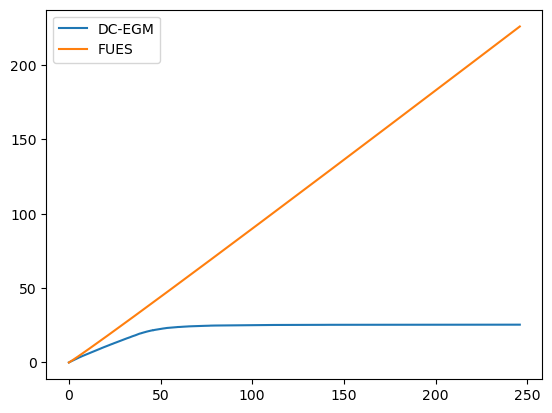

In [77]:
d = 0
d_aux = np.ones(len(mNrmGrid_New)) * d
plt.plot(mNrmGrid_New, cFuncKeep_DCEGM(d_aux, mNrmGrid_New), label = 'DC-EGM')
plt.plot(mNrmGrid_New, cFuncKeep(d_aux, mNrmGrid_New), label = 'FUES')
plt.legend()
plt.show()

### Period T-1: Adjuster
Now it gets interesting.

Math here:::